 **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import re
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load and Merge all 5 sentences column in one sentences column**

In [2]:
df = pd.read_csv("/content/ROCStories_winter2017.csv")

In [3]:
len(df)

52665

In [4]:
merge_df = df
merge_df['sentences'] = merge_df['sentence1']+' '+merge_df['sentence2']+' '+merge_df['sentence3']+' '+merge_df['sentence4']+' '+merge_df['sentence5']
merge_df.head()

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5,sentences
0,8bbe6d11-1e2e-413c-bf81-eaea05f4f1bd,David Drops the Weight,David noticed he had put on a lot of weight re...,He examined his habits to try and figure out t...,He realized he'd been eating too much fast foo...,He stopped going to burger places and started ...,"After a few weeks, he started to feel much bet...",David noticed he had put on a lot of weight re...
1,0beabab2-fb49-460e-a6e6-f35a202e3348,Frustration,Tom had a very short temper.,One day a guest made him very angry.,He punched a hole in the wall of his house.,Tom's guest became afraid and left quickly.,Tom sat on his couch filled with regret about ...,Tom had a very short temper. One day a guest m...
2,87da1a22-df0b-410c-b186-439700b70ba6,Marcus Buys Khakis,Marcus needed clothing for a business casual e...,All of his clothes were either too formal or t...,He decided to buy a pair of khakis.,The pair he bought fit him perfectly.,Marcus was happy to have the right clothes for...,Marcus needed clothing for a business casual e...
3,2d16bcd6-692a-4fc0-8e7c-4a6f81d9efa9,Different Opinions,Bobby thought Bill should buy a trailer and ha...,Bill thought a truck would be better for what ...,Bobby pointed out two vehicles were much more ...,Bill was set in his ways with conventional thi...,He ended up buying the truck he wanted despite...,Bobby thought Bill should buy a trailer and ha...
4,c71bb23b-7731-4233-8298-76ba6886cee1,Overcoming shortcomings,John was a pastor with a very bad memory.,He tried to memorize his sermons many days in ...,He decided to learn to sing to overcome his ha...,He then made all his sermons into music and sa...,His congregation was delighted and so was he.,John was a pastor with a very bad memory. He t...


**Finding the maximum length sentences in dataset**

In [5]:
max_len_sentence = 0;
for i in range(len(merge_df)):#this for loop running through the entire document
  res = len(re.findall(r'\w+', merge_df.loc[i,'sentences']))
  if(res>max_len_sentence):
    max_len_sentence = res

print(max_len_sentence)

74


 ## **Exploratory Data Analysis** and **Text Data Preprocessing**


In [38]:
vocab_size = 10000
tokenizer = Tokenizer(filters='#$^&*')
sentences = []
#here we are taking for 2500 records we can also increase the size.
for i in merge_df.loc[:2500,'sentences'].values: 
  corpus = i.lower().split('\n')
  tokenizer.fit_on_texts(corpus)
  sentences.append(corpus)

total_unique_words = len(tokenizer.word_index)+1


In [7]:
display(len(tokenizer.word_index),total_unique_words,len(sentences))

11822

11823

2501

In [8]:
sen_lengths = []
for i in sentences:
  sen_lengths.append(len(str(i).split(' ')))

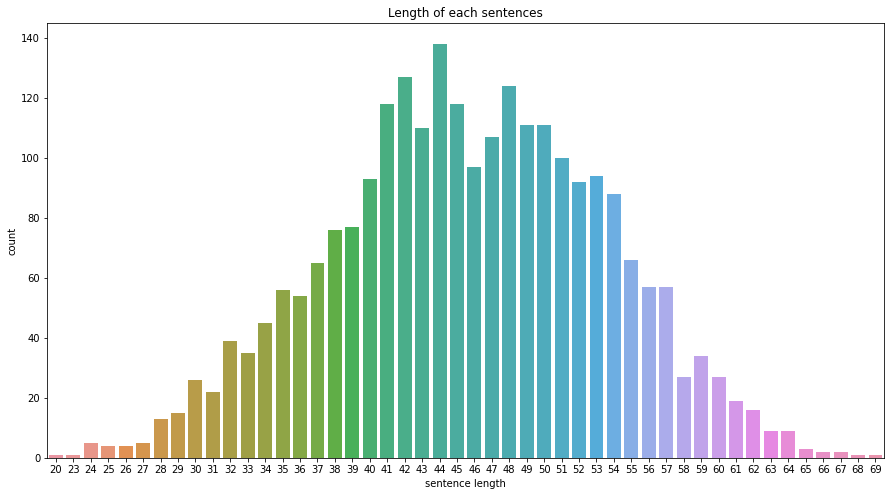

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Length of each sentences')
plt.xlabel('sentence length')
plt.ylabel('Counts')
sns.countplot(sen_lengths)
plt.show()

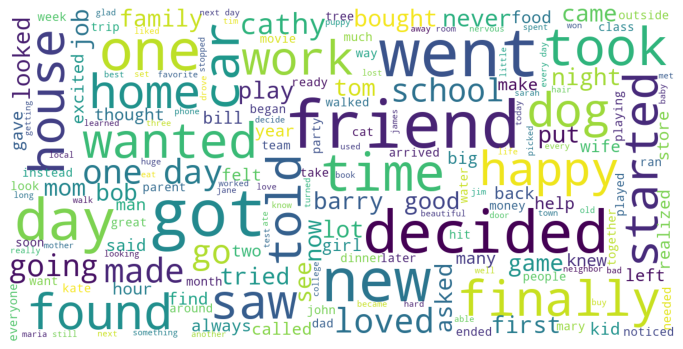

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(sentences)

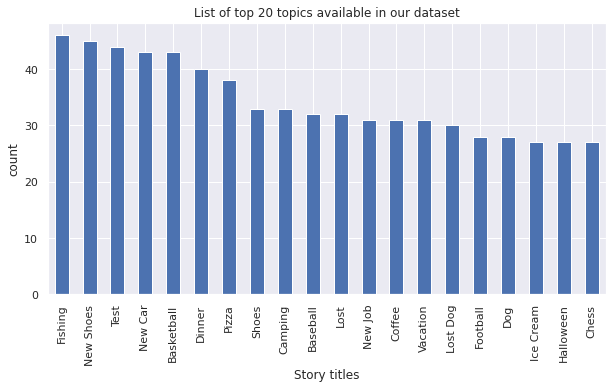

In [ ]:
plt.figure(figsize=(10,5))
plt.title('List of top 20 topics available in our dataset')
merge_df['storytitle'].value_counts().head(20).plot.bar()
plt.xlabel('Story titles')
plt.ylabel('count')
plt.show()

**Embedding each text to an integer value**

In [9]:
embeddings = []
for line in sentences:
  embeddings.append(tokenizer.texts_to_sequences(line)[0])

**Spliting the list into other list using n_gram_sequence(for predict the next suitable word)**

In [10]:
input_sequences = []

for embedding in embeddings:
  for j in range(1,len(embedding)):
    n_gram_sequence = embedding[:j+1]
    input_sequences.append(n_gram_sequence)

In [11]:
print(len(input_sequences))

111598


**Finding max len of sentence in sequence**

In [12]:
max =0;
for x in embeddings:
  if len(x) > max:
    max = len(x)
print(max)

69


**Pre Padding the values [Sequences will be padded to the length of the longest individual sequence]**

In [13]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen =max, padding='pre'))

In [14]:
input_sequences.shape

(111598, 69)

In [15]:
count = len(input_sequences)

In [16]:
input_sequences[:,-1]

array([ 192,    5,   14, ...,   12,    1, 2493], dtype=int32)

**Generating X values and labels**

In [17]:
x_value = input_sequences[:,:-1]
x_value.shape

(111598, 68)

In [18]:
x_value = np.array(x_value).reshape((x_value.shape[0],x_value.shape[1],1))
x_value.shape

(111598, 68, 1)

In [19]:
labels =input_sequences[:,-1]
len(labels)

111598

**Y values are categorical and one hot encoded**

In [20]:
y_values = tf.keras.utils.to_categorical(labels, num_classes=total_unique_words)

## **Training the Neural Network**  -- Approach 1 RNN_LSTM

In [28]:
def create_model():
  model = Sequential()
  model.add(LSTM(400, input_shape=(x_value.shape[1], x_value.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(400))
  model.add(Dropout(0.2))
  model.add(Dense(y_values.shape[1], activation='softmax'))
  #model.add(Dense(total_unique_words, activation='softmax'))
  return model

In [29]:
model1 = create_model()
adam = tf.keras.optimizers.Adam()
model1.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 68, 400)           643200    
_________________________________________________________________
dropout (Dropout)            (None, 68, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11823)             4741023   
Total params: 6,665,823
Trainable params: 6,665,823
Non-trainable params: 0
_________________________________________________________________


In [30]:
history=model1.fit(x_value, y_values, epochs = 30, batch_size = 128, verbose= 1)

Epoch 1/30
872/872 [==============================] - 101s 115ms/step - loss: 6.7681 - accuracy: 0.0606
Epoch 2/30
872/872 [==============================] - 101s 115ms/step - loss: 6.4020 - accuracy: 0.0771
Epoch 3/30
872/872 [==============================] - 101s 116ms/step - loss: 6.2047 - accuracy: 0.0835
Epoch 4/30
872/872 [==============================] - 100s 115ms/step - loss: 6.0198 - accuracy: 0.0892
Epoch 5/30
872/872 [==============================] - 101s 116ms/step - loss: 5.8487 - accuracy: 0.0947
Epoch 6/30
872/872 [==============================] - 101s 116ms/step - loss: 5.6741 - accuracy: 0.0998
Epoch 7/30
872/872 [==============================] - 101s 116ms/step - loss: 5.5138 - accuracy: 0.1027
Epoch 8/30
872/872 [==============================] - 101s 116ms/step - loss: 5.3625 - accuracy: 0.1065
Epoch 9/30
872/872 [==============================] - 101s 115ms/step - loss: 5.2155 - accuracy: 0.1093
Epoch 10/30
872/872 [==============================] - 101s 115m

In [39]:
from keras.preprocessing import sequence

input_words = "David"
count_words = 60

for i in range(count_words):
  token_list = tokenizer.texts_to_sequences([input_words])[0]
  token_list = pad_sequences([token_list], maxlen = max-1, padding='pre')
  token_list = token_list.reshape(-1,1)
  token_list = np.expand_dims(token_list,axis=0)
  predicted = model1.predict_classes(token_list, verbose=0)

  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  input_words += " " +output_word
print(input_words)

David was a very lonely person. he was falling to the lake. he bought a yacht and inexpensive the judges and went to the clerk. store he got to the bathroom he bought a great of the sunglasses he was so happy to be finished! he programmed the fiction and went the job! and was arrested. to the gape-jawed and found


## ** Approach 2 GPT2 **

In [32]:
!pip install -q git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 3.0MB 6.2MB/s 
     |████████████████████████████████| 1.1MB 22.2MB/s 
     |████████████████████████████████| 890kB 39.2MB/s 


In [33]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
input_ids = tokenizer.encode('Tom had a very short temper.', return_tensors='tf')

All model checkpoint weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Greedy Search

In [34]:
# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Tom had a very short temper. He was very angry and he was very angry. He was very angry. He was very angry. He was very angry. He was very angry. He was very angry. He was very angry. He was very


Beam Search

In [36]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids, 
    max_length=60, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Tom had a very short temper.

"I don't know what you're talking about," he said. "I'm not going to tell you what to do. I just want you to know that I love you, and I want to be with you for the rest of my life."


## ** Approach 3 Bi_LSTM **

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def create_model():
  #n_timesteps = 10
  model = Sequential()
  model.add(Embedding(total_unique_words, 200, input_length=max-1))
  model.add(Bidirectional(LSTM(150, return_sequences=True)))
  model.add(Flatten())
  model.add(Dense(total_unique_words, activation='softmax'))
  return model

In [22]:
model = create_model()
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 200)           2364600   
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 300)           421200    
_________________________________________________________________
flatten (Flatten)            (None, 20400)             0         
_________________________________________________________________
dense (Dense)                (None, 11823)             241201023 
Total params: 243,986,823
Trainable params: 243,986,823
Non-trainable params: 0
_________________________________________________________________


## Using Pre-Trained model

In [ ]:
from google.colab import drive
drive.mount('/content/tmp')

In [ ]:
pre_trained_model = tf.keras.models.load_model('/content/tmp/My Drive/my_model.h5')

In [ ]:
#pre_trained_model.save_weights('my_model_weights')
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
pre_trained_model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 200)           2083000   
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 300)           421200    
_________________________________________________________________
flatten (Flatten)            (None, 20400)             0         
_________________________________________________________________
dense (Dense)                (None, 10415)             212476415 
Total params: 214,980,615
Trainable params: 214,980,615
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_values.shape

(89787, 10650)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4, monitor='accuracy')
checkpoint_dir = '/content/'
history=pre_trained_model.fit(
    x_value, y_values, 
    epochs = 100, verbose= 1,
    batch_size=128,
    callbacks = [early_stop]
    )

Epoch 1/100


ValueError: ignored

## Using new model

In [23]:
# Creating early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=4, monitor='accuracy')

In [24]:
checkpoint_dir = '/content/'
history=model.fit(
    x_value, y_values, 
    epochs = 100, verbose= 1,
    batch_size=128,
    callbacks = [early_stop,tf.keras.callbacks.ModelCheckpoint(
            os.path.join(checkpoint_dir, 'epoch_{epoch:02d}_acc_{accuracy:.4f}'),
            monitor='accuracy', save_weights_only=True, save_best_only=True
        )]
    )

Epoch 1/100
872/872 [==============================] - 262s 300ms/step - loss: 6.5058 - accuracy: 0.1227
Epoch 2/100
872/872 [==============================] - 258s 296ms/step - loss: 3.6230 - accuracy: 0.3339
Epoch 3/100
872/872 [==============================] - 257s 295ms/step - loss: 1.5756 - accuracy: 0.6367
Epoch 4/100
872/872 [==============================] - 258s 296ms/step - loss: 1.0164 - accuracy: 0.7494
Epoch 5/100
872/872 [==============================] - 259s 297ms/step - loss: 0.8079 - accuracy: 0.7960
Epoch 6/100
872/872 [==============================] - 259s 297ms/step - loss: 0.7297 - accuracy: 0.8140
Epoch 7/100
872/872 [==============================] - 257s 295ms/step - loss: 0.6508 - accuracy: 0.8336
Epoch 8/100
872/872 [==============================] - 257s 294ms/step - loss: 0.5749 - accuracy: 0.8519
Epoch 9/100
872/872 [==============================] - 257s 295ms/step - loss: 0.5608 - accuracy: 0.8570
Epoch 10/100
872/872 [==============================] -

In [ ]:
model.save('my_model.h5')

## Generating story with trained model

In [26]:
max = 69
init_text = "david"
gen_words = 50

for i in range(gen_words):
  token_list = tokenizer.texts_to_sequences([init_text])[0]
  token_list = pad_sequences([token_list], maxlen =max-1, padding='pre')
  pred = model.predict_classes(token_list)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == pred:
      output_word = word
      break
    
  init_text += " "+ word

print(init_text)



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
david was walking down his street and he felt down. he stood up and saw that his knee was bleeding. he found a handkerchief in his pants was applied it had the wound. he hopped the and nearest pharmacy stifling his pain. he then his some peroxide and bandages to treat


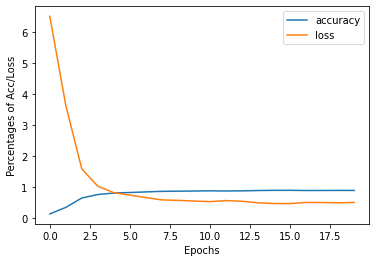

In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["loss"])
  plt.xlabel("Epochs")
  plt.ylabel("Percentages of Acc/Loss")
  plt.legend(["accuracy","loss"])
  plt.show()
  
plot_graphs(history)